# Reduced-dimension Emulator: Reaction-Diffusion example

### Overview
In this example, we aim to create an _emulator_ to generate solutions to a 2D parameterized reaction-diffusion problem governed by the following partial differential equations:

$$
\dot{u} = (1 - (u^2 + v^2)) u + \beta (u^2 + v^2) v + d (u_{xx} + u_{yy}),
$$
$$
\dot{v} = -\beta (u^2 + v^2) u + (1 - (u^2 + v^2)) v + d (v_{xx} + v_{yy}),
$$

where:
- $ u $ and $ v $ are the concentrations of two species,
- $ \beta $ and $ d $ control the reaction and diffusion terms.

This system exhibits complex spatio-temporal dynamics such as spiral waves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm
import os

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.reaction_diffusion import simulate_reaction_diffusion
from autoemulate.compare import AutoEmulate
from autoemulate.plotting import _predict_with_optional_std

save = False
train = False

/Users/pconti/Desktop/AutoEmulator/autoemulate/autoemulate/compare.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 1) Data generation
Data are computed using a numerical [_simulator_](https://github.com/dynamicslab/pysindy/blob/master/examples/10_PDEFIND_examples.ipynb) using Fourier spectral method.
The simulator takes two inputs: the reaction parameter $\beta$ and the diffusion parameter $d$.

We sample 50 sets of inputs `X` using Latin Hypercube sampling and run the simulator for those inputs to get the solutions `Y`.


In [2]:
n = 50

# Reaction-diffusion parametersç
beta = (1., 2.) # lower and upper bounds for the reaction coefficient
d = (0.05, 0.3) # lower and upper bounds for the diffusion coefficient
lhd = LatinHypercube([beta, d])
n_samples = 50
X = lhd.sample(n_samples)

# Create the data folder if it doesn't exist
data_folder = "../data/reaction_diffusion"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)  
X_file = os.path.join(data_folder, "X.csv")
Y_file = os.path.join(data_folder, "Y.csv")

if train:
    U, V = zip(*[simulate_reaction_diffusion(x, n=n, T=10) for x in tqdm(X)])
    U = np.stack(U)
    V = np.stack(V)

    # Let's consider as output the concentration of the specie U
    Y = U.reshape(n_samples, -1)

    if save:
        # Save the data
        pd.DataFrame(X).to_csv(X_file, index=False)
        pd.DataFrame(Y).to_csv(Y_file, index=False)
else:
    # Load the data
    X = pd.read_csv(X_file).values
    Y = pd.read_csv(Y_file).values

print(f"shapes: input X: {X.shape}, output Y: {Y.shape}\n")

shapes: input X: (50, 2), output Y: (50, 2500)



`X` and `Y` are matrices where each row represents one run of the simulation.  In the input matrix `X` each column is a different input parameters. 
In the output matrix `Y` each column indicates a spatial location where the solution (i.e. the concentration of $U$ at final time $T$) is computed. <br>
We consider a 2D spatial grid of $32\times 32$ points, therefore each row of `Y` corresponds to a 1024-dimensional vector!

Let’s now plot the simulated data to see how the reaction-diffusion pattern looks like.

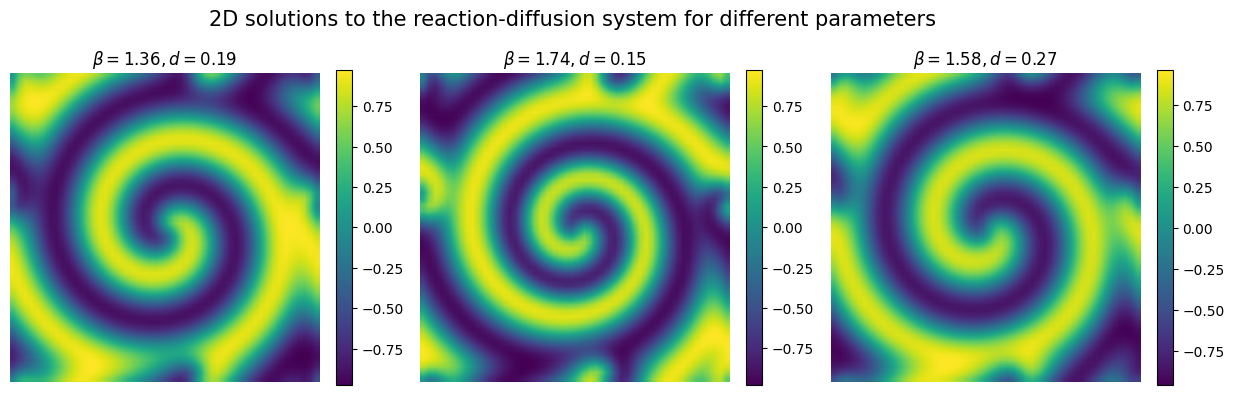

In [3]:
plt.figure(figsize=(15,4.5))
for param in range(3):
  plt.subplot(1,3,1+param)
  plt.imshow(Y[param].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title(r'$\beta = {:.2f}, d = {:.2f}$'.format(X[param][0], X[param][1]), fontsize=12)
  plt.colorbar(fraction=0.046)
plt.suptitle('2D solutions to the reaction-diffusion system for different parameters', fontsize=15)
plt.show()

## 2) Reduced-dimension Emulator
The numerical simulator is computationally expensive to run, thus we aim to replace it with a fast _emulator_.
As output we aim to emulate is the full spatial fields of the concentration of $U$ which is high-dimensional, we employ dimensionality reduction techniques to create a faster and more efficient emulator.

You can do so by selecting `reduce_dim_output=True` and indicate which dimensionality reducer `dim_reducer_output` you want to use among:
- `"PCA"`: Principal Component Analysis (deafult),
- `"VAE"`: Variational Autoencoder,

which will be trained together with the emulator.

In [4]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
em = AutoEmulate()

preprocessing_methods = [{"name" : "VAE", "params" : {"reduced_dim": 8}},
                         {"name" : "VAE", "params" : {"reduced_dim": 32}},
                         {"name" : "PCA", "params" : {"reduced_dim": 8}}]

em.setup(X, Y, models=["gp"], scale_output = True, reduce_dim_output=True, preprocessing_methods=preprocessing_methods)

best_model = em.compare()

,Values
Simulation input shape (X),"(50, 2)"
Simulation output shape (y),"(50, 2500)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Cross-validating:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
best_model

{'preprocessing': 'PCA',
 'model': 'GaussianProcess',
 'transformer': 'PCA(n_components=8)'}

## 3) Summarising cross-validation results
We can look at the cross-validation results to see which model provides the best emulator. 

In [6]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,PCA,GaussianProcess,gp,1,0.027728,0.996352
1,PCA,GaussianProcess,gp,0,0.044707,0.992585
2,PCA,GaussianProcess,gp,4,0.055715,0.989539
3,PCA,GaussianProcess,gp,3,0.077578,0.977710
4,PCA,GaussianProcess,gp,2,0.103177,0.907660
5,VAE,GaussianProcess,gp,0,0.088152,0.967808
6,VAE,GaussianProcess,gp,4,0.121241,0.957428
7,VAE,GaussianProcess,gp,1,0.118559,0.952127
8,VAE,GaussianProcess,gp,2,0.102296,0.938219
9,VAE,GaussianProcess,gp,3,0.157709,0.928293


We can select the best performing emulator model (in this case GaussianProcess) and see how it performs on the test-set, which AutoEmulate automatically sets aside.

We can plot the test-set performance for chosen emulator.

In [7]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,PCA,0.0681,0.983


In [8]:
gp

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=8))]))

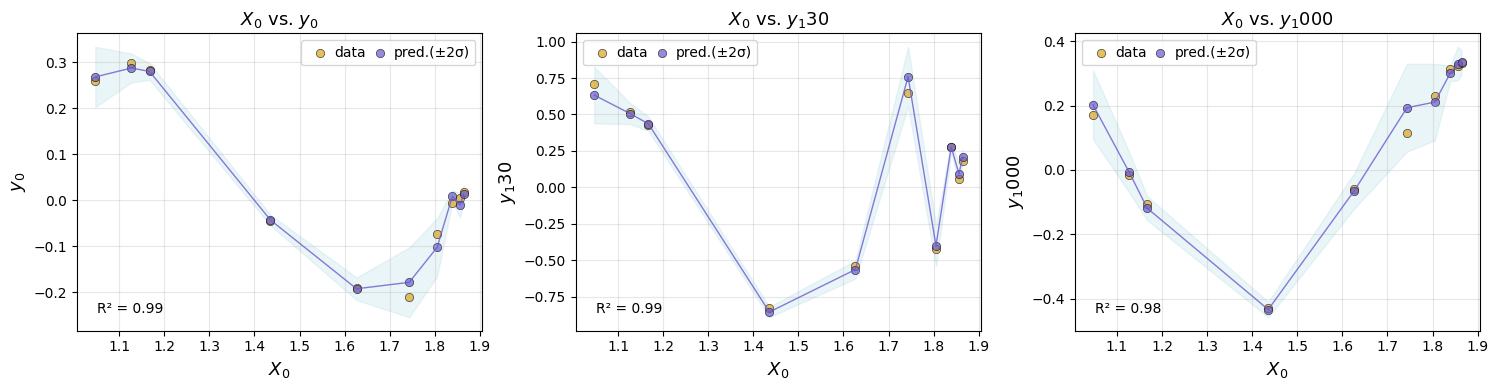

In [9]:
em.plot_eval(gp, input_index=[0], output_index=[0,130, 1000])

## 4) Refitting the model on the full dataset
AutoEmulate splits the dataset into a training and holdout set. All cross-validation, parameter optimisation and model selection is done on the training set. After we selected a best emulator model, we can refit it on the full traiing dataset.

In [10]:
gp_final = em.refit(gp)

In [11]:
gp_final

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=8))]))

## 5) Predict on the test set
Now we run the emulator for unseen combinations of reaction and diffusion parameter and we compare its performance with respect to the reference (simulator)

In [12]:
#y_pred = gp_final.predict(X[em.test_idxs]) #TODO: fix this
y_pred, y_std_pred = _predict_with_optional_std(gp_final, X[em.test_idxs])
y_true = Y[em.test_idxs]

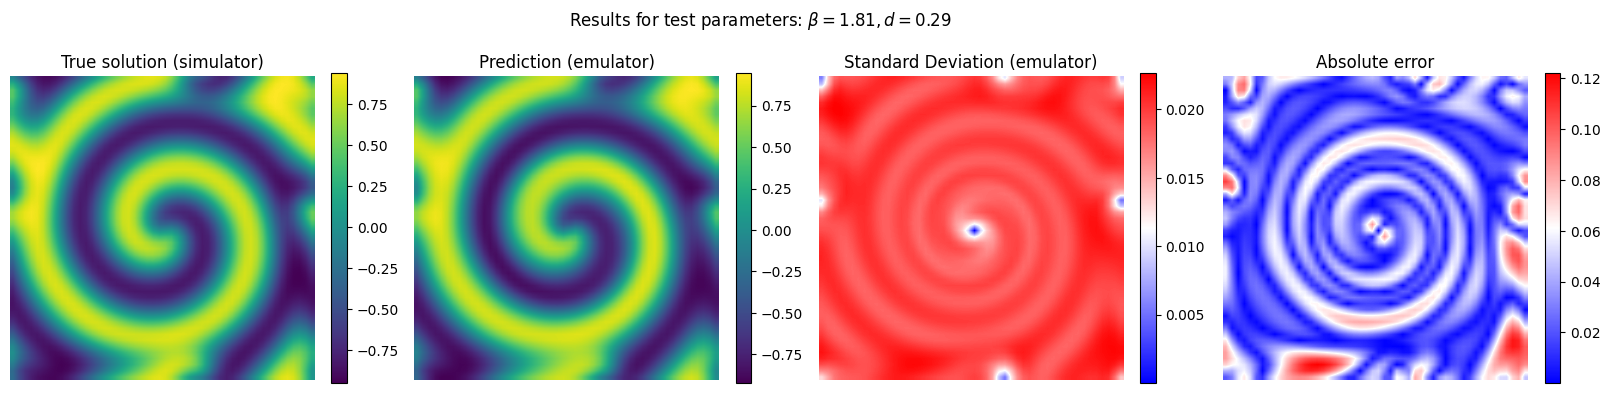

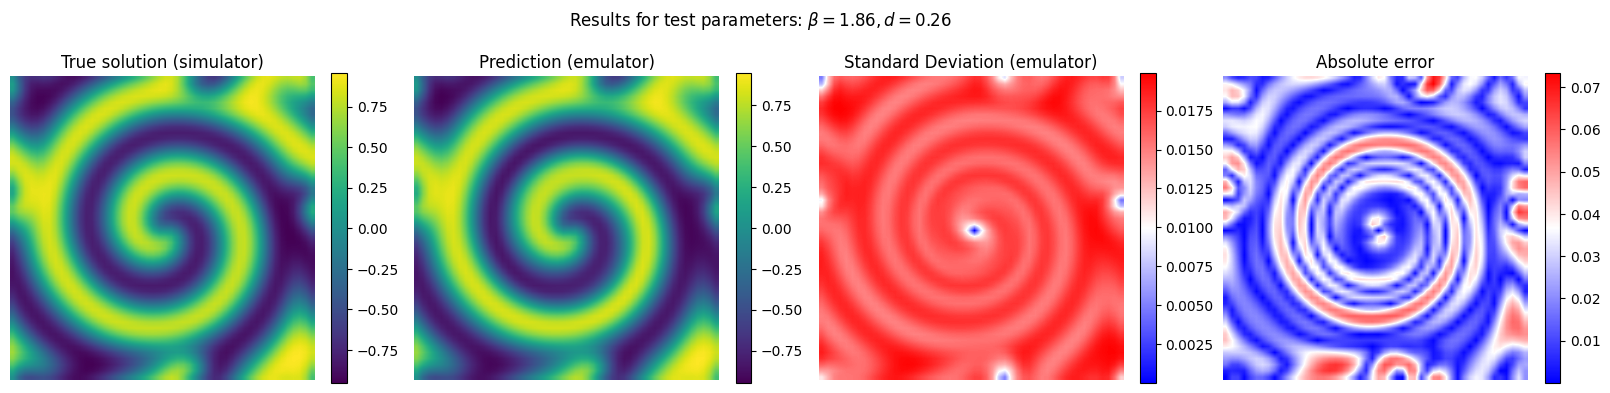

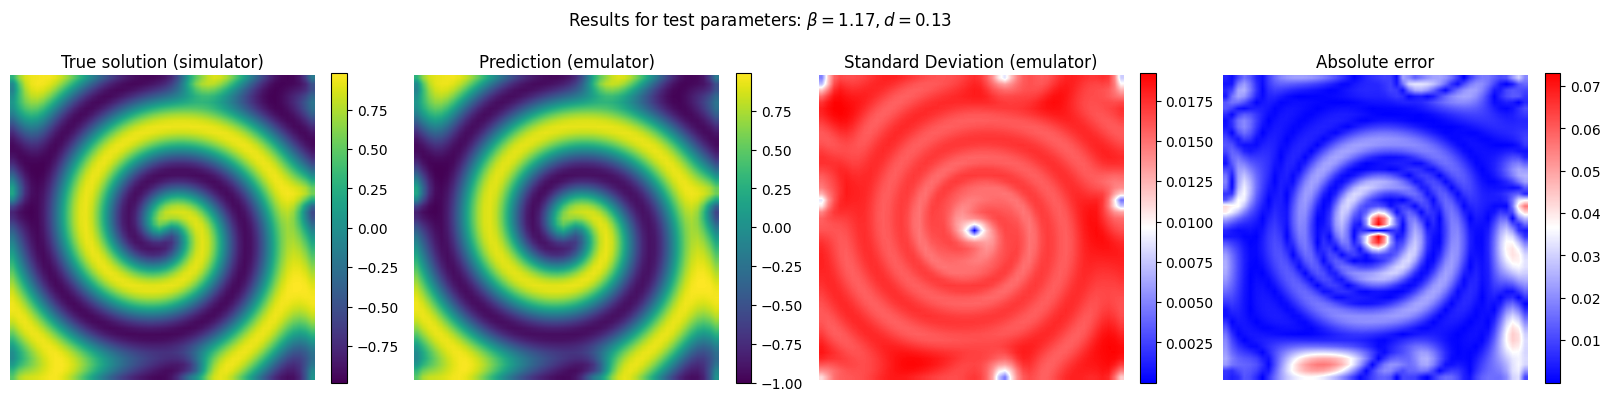

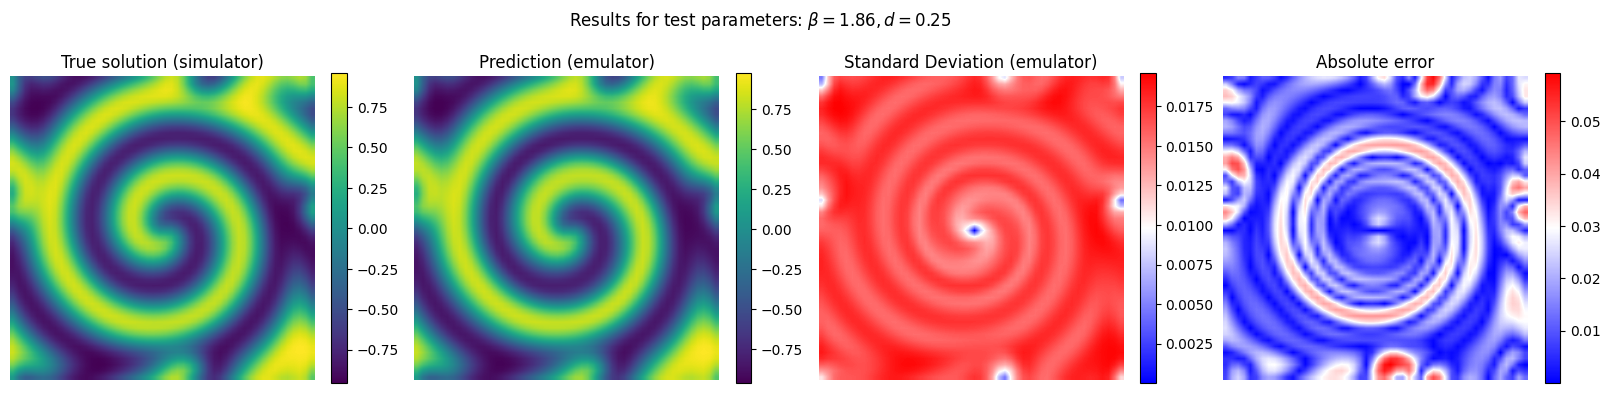

In [13]:
# Plot the results for some unseen (test) parameter instances
params_test = [0,1,2,3]

for param_test in params_test:
  plt.figure(figsize=(20,4.5))
  plt.subplot(1,4,1)
  plt.imshow(y_true[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('True solution (simulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,4,2)
  plt.imshow(y_pred[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Prediction (emulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,4,3)
  plt.imshow(y_std_pred[param_test].reshape(n,n), cmap = 'bwr', interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Standard Deviation (emulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,4,4)
  plt.imshow(np.abs(y_pred[param_test] - y_true[param_test]).reshape(n,n), cmap = 'bwr', interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Absolute error', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.suptitle(r'Results for test parameters: $\beta = {:.2f}, d = {:.2f}$'.format(X[em.test_idxs][param_test][0], X[em.test_idxs][param_test][1]), fontsize=12)
  plt.show()

Using best preprocessing method: PCA

Preprocessing Configuration:
Method: PCA
Hyperparameters:
  reduced_dim: 8
Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


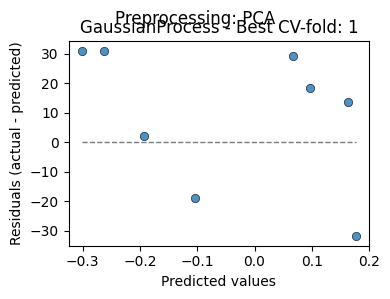

In [14]:
em.plot_cv(style="residual_vs_predicted")